In [1]:
!nvidia-smi

Wed Oct 20 10:33:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.03   Driver Version: 450.119.03   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 6000     Off  | 00000000:01:00.0 Off |                  Off |
| 33%   42C    P8    23W / 260W |  16370MiB / 24220MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro RTX 6000     Off  | 00000000:81:00.0 Off |                  Off |
| 34%   

In [6]:
!pip install torchtuples
!pip install pycox
!pip install timm
!pip install albumentations

You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.


In [2]:
import torchtuples as tt
from pycox.models import LogisticHazard, PMF, MTLR, BCESurv
from pycox.utils import kaplan_meier
from pycox.evaluation import EvalSurv

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader 

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
# import pydicom as pdm

import timm
from pprint import pprint

import copy
from tqdm import tqdm
import pickle
from sklearn import metrics
from glob import glob

from load_data import load_data
from PIL import Image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Data Loading

In [3]:
%%time
batch_size = 32
image_datasets, dataloaders, dataset_sizes, labtrans = load_data('copd_np', 'copd', batch_size, '/home/COPD/DATA/COPD_PNG', '/home/COPD/DATA/COPD_train_new.csv')

Project:  copd_np
aug mode: copd
batchsize:  32
CPU times: user 461 ms, sys: 13.5 ms, total: 475 ms
Wall time: 474 ms


In [4]:
image_datasets

{'train': <load_data.COPDdatasetNP at 0x7f7ee5abb6d8>,
 'val': <load_data.COPDdatasetNP at 0x7f7ee5abbcc0>,
 'test': <load_data.COPDdatasetNP at 0x7f7ee5abbda0>}

In [5]:
image_datasets['train'].time,\
image_datasets['train'].event

(tensor([ 2,  4, 18,  ...,  1,  9,  9]),
 tensor([1., 1., 0.,  ..., 1., 0., 0.]))

In [6]:
dataset_sizes

{'train': 3474, 'val': 435, 'test': 434}

In [7]:
images, labels = next(iter(dataloaders['train']))

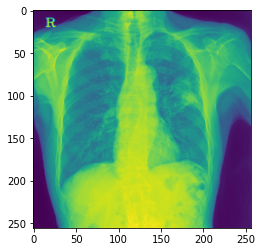

In [8]:
plt.imshow(images[0][0])

In [9]:
images[0].size()

torch.Size([3, 256, 256])

In [10]:
labels

[tensor([ 2,  4, 18,  9,  6, 11, 10, 15, 10, 10,  3, 11,  9,  2, 10,  9,  9,  9,
          9,  3,  1, 12,  9,  2, 16, 10, 17, 15, 17, 14, 13, 17]),
 tensor([1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0.,
         0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])]

## Model Training

In [11]:
model_ft = timm.create_model('densenet121', pretrained=True, num_classes=5)

In [16]:
model_ft = timm.create_model('resnet50', pretrained=True, num_classes=5)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet50_ram-a26f946b.pth" to /root/.cache/torch/hub/checkpoints/resnet50_ram-a26f946b.pth


In [12]:
# transfer learning block
model_ft.load_state_dict(torch.load('pretrained/5_jama_den121.pth'))

<All keys matched successfully>

In [18]:
# transfer learning block
model_ft.load_state_dict(torch.load('pretrained/5_jama_res50.pth'))

<All keys matched successfully>

In [13]:
# DenseNet 121
num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Linear(num_ftrs, labtrans.out_features)

In [19]:
# ResNet 50
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, labtrans.out_features)

In [20]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act3): ReLU(inplace=True)
      (downsample): Sequen

In [ ]:
model = LogisticHazard(model_ft, tt.optim.Adam(0.0001), duration_index=labtrans.cuts)

In [28]:
# earlystopping metric은 어디에서 지정?
# lr_scheduler

callbacks = [tt.cb.EarlyStopping(patience=10)]
epochs = 200
verbose = True
log = model.fit_dataloader(dataloaders['train'], epochs, callbacks, verbose, val_dataloader=dataloaders['val'])

0:	[21s / 21s],		train_loss: 2.5533,	val_loss: 1.4173
1:	[19s / 41s],		train_loss: 1.3558,	val_loss: 1.3926
2:	[20s / 1m:1s],		train_loss: 1.2607,	val_loss: 1.3852
3:	[19s / 1m:21s],		train_loss: 1.1879,	val_loss: 1.4062
4:	[20s / 1m:41s],		train_loss: 1.1258,	val_loss: 1.4712
5:	[20s / 2m:1s],		train_loss: 1.0543,	val_loss: 1.4784
6:	[19s / 2m:21s],		train_loss: 0.9899,	val_loss: 1.4504
7:	[20s / 2m:42s],		train_loss: 0.9113,	val_loss: 1.4894
8:	[20s / 3m:3s],		train_loss: 0.8187,	val_loss: 1.5845
9:	[19s / 3m:22s],		train_loss: 0.7439,	val_loss: 1.6215
10:	[20s / 3m:43s],		train_loss: 0.6731,	val_loss: 1.6592
11:	[20s / 4m:3s],		train_loss: 0.5972,	val_loss: 1.6554
12:	[19s / 4m:22s],		train_loss: 0.5085,	val_loss: 1.7126


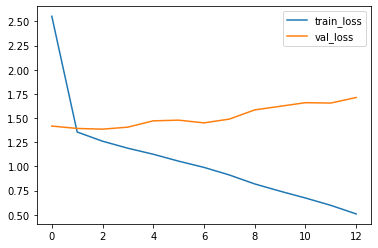

In [29]:
_ = log.plot()

## Model Evaluate

In [32]:
class ImgSimInput(Dataset):
    def __init__(self, img_dataset):
        self.img_dataset = img_dataset

    def __len__(self):
        return len(self.img_dataset)

    def __getitem__(self, index):
        img = self.img_dataset[index][0]
        return img

In [33]:
dataset_test_x = ImgSimInput(image_datasets['test'])
dl_test_x = DataLoader(dataset_test_x, batch_size, shuffle=False)

In [34]:
import pandas as pd

In [39]:
df = pd.read_csv('../DATA/COPD_train_new.csv')
df

,inclusion,training,val,test,ext,error,exclusion,censor,5YSR,survival
0,1,NaN,NaN,1.0,NaN,NaN,0,0.0,1,2214.0
1,2,1.0,NaN,NaN,NaN,NaN,1,1.0,0,251.0
2,3,1.0,NaN,NaN,NaN,NaN,0,1.0,0,564.0
3,5,NaN,1.0,NaN,NaN,NaN,1,0.0,1,1727.0
4,7,NaN,1.0,NaN,NaN,NaN,0,1.0,0,575.0
...,...,...,...,...,...,...,...,...,...,...
4397,4915,1.0,NaN,NaN,NaN,NaN,0,0.0,1,1661.0
4398,4916,1.0,NaN,NaN,NaN,NaN,1,1.0,0,405.0
4399,4917,1.0,NaN,NaN,NaN,NaN,1,1.0,0,135.0
4400,4918,1.0,NaN,NaN,NaN,NaN,0,0.0,1,1653.0


In [41]:
def event_time(split, image_datasets=image_datasets, df=df):
    time_lst = []
    event_lst = []
    for i in image_datasets[split].imgs_lst:
        idx = i.split('/')[-1].split('.')[0]
        time_lst.append(df[df['inclusion'] == int(idx)].survival.values[0])
        event_lst.append(df[df['inclusion'] == int(idx)].censor.values[0])
    return (np.array(time_lst), np.array(event_lst))

In [60]:
sim_train = event_time('train')
sim_val = event_time('val')
sim_test = event_time('test') 

In [72]:
surv = model.interpolate(10).predict_surv_df(dl_test_x)
# interpolate 없으면 3475일을 20등분해서 표현. interpolate(10) 때문에 20*10=200 등분해서 표현

In [73]:
surv

,0,1,2,3,4,5,6,7,8,9,...,424,425,426,427,428,429,430,431,432,433
0.000000,0.994645,0.992076,0.995118,0.995598,0.989158,0.997503,0.995658,0.993637,0.994572,0.991343,...,0.990527,0.994027,0.973170,0.998217,0.993534,0.991610,0.989888,0.995157,0.994274,0.996090
18.289474,0.994101,0.987683,0.994901,0.994883,0.982871,0.997185,0.991570,0.990401,0.992774,0.989633,...,0.981962,0.992691,0.940229,0.998152,0.991522,0.988415,0.977334,0.994325,0.993609,0.994857
36.578947,0.993557,0.983291,0.994684,0.994167,0.976584,0.996866,0.987483,0.987165,0.990975,0.987924,...,0.973396,0.991355,0.907287,0.998087,0.989511,0.985221,0.964779,0.993493,0.992944,0.993625
54.868421,0.993013,0.978899,0.994466,0.993451,0.970297,0.996548,0.983396,0.983929,0.989177,0.986214,...,0.964830,0.990019,0.874346,0.998022,0.987499,0.982027,0.952225,0.992661,0.992278,0.992392
73.157895,0.992469,0.974507,0.994249,0.992736,0.964010,0.996230,0.979309,0.980694,0.987379,0.984504,...,0.956264,0.988683,0.841404,0.997957,0.985487,0.978832,0.939671,0.991828,0.991613,0.991159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3401.842105,0.529849,0.230376,0.593633,0.542189,0.272804,0.603730,0.366442,0.286474,0.381617,0.391373,...,0.217173,0.421660,0.014553,0.632547,0.408101,0.316057,0.179363,0.424144,0.488714,0.442473
3420.131579,0.493120,0.215168,0.548266,0.499904,0.252805,0.560214,0.340203,0.271619,0.345467,0.364653,...,0.202854,0.390239,0.013547,0.579815,0.376135,0.293320,0.169533,0.388651,0.446212,0.410421
3438.421053,0.456391,0.199961,0.502899,0.457619,0.232807,0.516698,0.313963,0.256763,0.309316,0.337933,...,0.188535,0.358818,0.012541,0.527083,0.344170,0.270584,0.159703,0.353158,0.403710,0.378368
3456.710526,0.419661,0.184753,0.457531,0.415334,0.212808,0.473182,0.287724,0.241908,0.273165,0.311213,...,0.174216,0.327397,0.011535,0.474351,0.312204,0.247847,0.149873,0.317665,0.361207,0.346316


In [63]:
ev = EvalSurv(surv, *sim_test, 'km') # Estimate using Kaplan-Meier Method

In [49]:
round(ev.concordance_td(), 4)

0.7372

In [50]:
def time_label(index_time, sim_test=sim_test):
    label_lst = []                  # 예측 생존 여부
    for i in range(len(sim_test[0])):
        dur = sim_test[0][i]        # 실제 생존 기간
        evt = sim_test[1][i]        # 최종 follow up 당시 생존 여부 (0: 생존, 1: 사망)
        if evt == 0:
            label_lst.append(0)
        elif evt == 1:
            if dur > index_time:    # 최종 follow up 기간 이후에 사망하는 걸로 예측되었다면, 생존으로 표기
                label_lst.append(0)
            else:
                label_lst.append(1)
        else:
            print("Something wrong!")
    return label_lst

In [51]:
fpr = dict()
tpr = dict()
auc = dict()
for year in [1, 3, 5]:
    auc[year] = metrics.roc_auc_score(time_label(int(surv.index[20*year])), -surv.iloc[20*year].values+1)
    fpr[year], tpr[year], _ = metrics.roc_curve(time_label(int(surv.index[20*year])), -surv.iloc[20*year].values+1)
    print(round(auc[year], 4))

0.8211
0.7695
0.7729


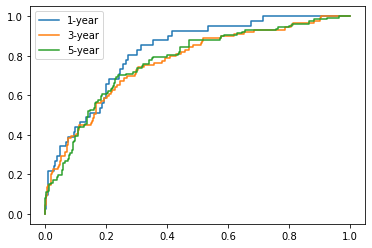

In [52]:
for year in [1, 3, 5]:
    plt.plot(fpr[year], tpr[year], label=f"{year}-year")
plt.legend()

In [53]:
PATH = './results/den121_s256_jama_albu_c76'

In [54]:
torch.save(model.net.state_dict(), f"{PATH}.pt")

In [55]:
surv.to_csv(f"{PATH}.csv", index=False)

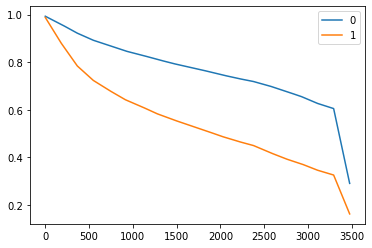

In [56]:
for i in range(2):
    idx = sim_test[1] == i
    surv.loc[:, idx].mean(axis=1).rename(i).plot()
_ = plt.legend()

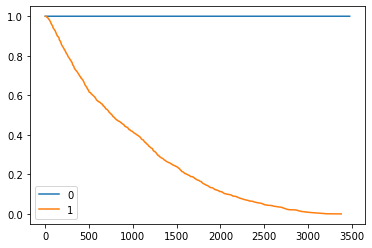

In [57]:
for i in range(2):
    idx = sim_train[1] == i
    kaplan_meier(sim_train[0][idx], sim_train[1][idx]).rename(i).plot()
_ = plt.legend()

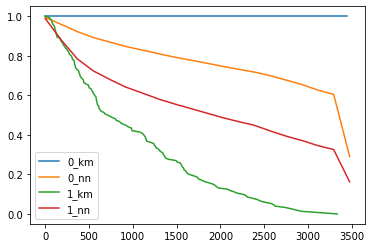

In [58]:
for i in range(2):
    idx = sim_test[1] == i
    kaplan_meier(sim_test[0][idx], sim_test[1][idx]).rename(f"{i}_km").plot()
    surv.loc[:, idx].mean(axis=1).rename(f"{i}_nn").plot()

_ = plt.legend()

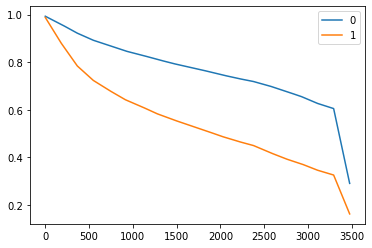

In [59]:
for i in range(2):
    idx = sim_test[1] == i
    surv.loc[:, idx].mean(axis=1).rename(i).plot()
_ = plt.legend()